In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from math import ceil
from sklearn.metrics import accuracy_score, log_loss
import torch
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append('../training_utils/')
from data_utils import get_folders, get_class_weights
from train_utils import train, predict
from diagnostic_tools import top_k_accuracy, per_class_accuracy,\
    count_params, entropy, model_calibration, show_errors, most_confused_classes,\
    most_inaccurate_k_classes
    
torch.cuda.is_available()

True

In [3]:
torch.backends.cudnn.benchmark = True

# Create data iterators

In [4]:
batch_size = 32

In [5]:
train_folder, val_folder = get_folders()

train_iterator = DataLoader(
    train_folder, batch_size=batch_size, num_workers=4,
    shuffle=True, pin_memory=True
)

val_iterator = DataLoader(
    val_folder, batch_size=64, num_workers=4,
    shuffle=False, pin_memory=True
)

# number of training samples
train_size = len(train_folder.imgs)
train_size

16980

# Model

In [6]:
from get_resnet18 import get_model

In [7]:
# w[j]: 1/number_of_samples_in_class_j
# decode: folder name to class name (in human readable format)
w, decode = get_class_weights(val_folder.class_to_idx)

In [8]:
model, criterion, optimizer = get_model(class_weights=torch.FloatTensor(w/w.sum()))

In [9]:
# number of params in the model
count_params(model)

11307840

# Train

In [10]:
n_epochs = 20
n_batches = ceil(train_size/batch_size)
# number of cycles
M = 1 
# total number of optimization steps
T = n_batches*n_epochs 
# initial learning rates
initial1 = 1e-2
initial2 = 1e-3
n_batches

531

In [11]:
# cyclical cosine annealing
# it changes the learning rate on every optimization step
# 1e-6 is the minimal learning rate
def lr_scheduler(optimizer, step):
    
    global initial1
    global initial2
    decay = np.cos(np.pi*((step - 1) % (T // M))/(T // M)) + 1.0
    
    # params of the last fc layer
    for param_group in optimizer.param_groups[:2]:
        param_group['lr'] = ((initial1 - 1e-6)*decay/2.0) + 1e-6
    
    # params of the last two resnet blocks
    for param_group in optimizer.param_groups[2:]:
        param_group['lr'] = ((initial2 - 1e-6)*decay/2.0) + 1e-6
    
    if (step - 1) % (T // M) == 0 and step != 1:
        print('lr is reset')
        
    return optimizer

In [12]:
%%time
all_losses, _ = train(
    model, criterion, optimizer, 
    train_iterator, n_epochs, n_batches, 
    val_iterator, validation_step=531, n_validation_batches=80, 
    saving_step=None, lr_scheduler=lr_scheduler
)
# epoch logloss    accuracy     top5_accuracy time  (first value: train, second value: val)

1.00  3.569 1.545  0.288 0.637  0.524 0.857  93.451
2.00  2.163 1.206  0.507 0.706  0.778 0.904  93.068
3.00  1.819 1.097  0.575 0.726  0.828 0.907  93.145
4.00  1.623 1.096  0.614 0.740  0.851 0.917  93.128
5.00  1.478 0.992  0.642 0.751  0.862 0.919  92.787
6.00  1.331 0.969  0.668 0.769  0.882 0.922  92.788
7.00  1.214 0.900  0.700 0.773  0.895 0.929  92.535
8.00  1.109 0.883  0.715 0.777  0.907 0.933  93.279
9.00  1.028 0.880  0.731 0.782  0.917 0.936  92.901
10.00  0.972 0.850  0.745 0.792  0.920 0.932  92.677
11.00  0.902 0.833  0.762 0.793  0.930 0.935  92.582
12.00  0.840 0.830  0.776 0.796  0.935 0.937  92.692
13.00  0.792 0.809  0.783 0.799  0.938 0.939  92.813
14.00  0.742 0.786  0.798 0.809  0.945 0.939  93.032
15.00  0.732 0.788  0.799 0.809  0.944 0.940  92.790
16.00  0.706 0.782  0.809 0.807  0.948 0.940  92.745
17.00  0.688 0.779  0.812 0.810  0.948 0.939  92.591
18.00  0.667 0.779  0.818 0.810  0.951 0.940  92.879
19.00  0.650 0.776  0.819 0.810  0.956 0.941  93.202
20

# Loss/epoch plots

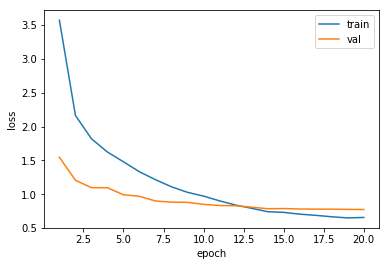

In [13]:
epochs = [x[0] for x in all_losses]
plt.plot(epochs, [x[1] for x in all_losses], label='train');
plt.plot(epochs, [x[2] for x in all_losses], label='val');
plt.legend();
plt.xlabel('epoch');
plt.ylabel('loss');

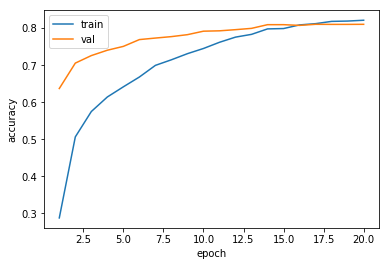

In [14]:
plt.plot(epochs, [x[3] for x in all_losses], label='train');
plt.plot(epochs, [x[4] for x in all_losses], label='val');
plt.legend();
plt.xlabel('epoch');
plt.ylabel('accuracy');

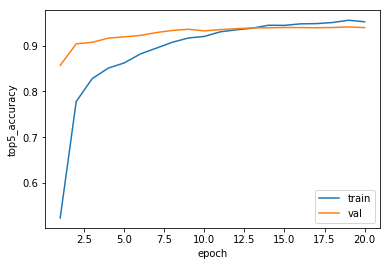

In [15]:
plt.plot(epochs, [x[5] for x in all_losses], label='train');
plt.plot(epochs, [x[6] for x in all_losses], label='val');
plt.legend();
plt.xlabel('epoch');
plt.ylabel('top5_accuracy');

# Error analysis

### get human readable class names

In [16]:
# index to class name
decode = {val_folder.class_to_idx[k]: decode[int(k)] for k in val_folder.class_to_idx}

### get all predictions and all misclassified images 

In [17]:
val_iterator_no_shuffle = DataLoader(
    val_folder, batch_size=64, shuffle=False
)

In [18]:
val_predictions, val_true_targets,\
    erroneous_samples, erroneous_targets,\
    erroneous_predictions = predict(model, val_iterator_no_shuffle, return_erroneous=True)
# erroneous_samples: images that were misclassified
# erroneous_targets: their true labels
# erroneous_predictions: predictions for them

100%|██████████| 80/80 [00:19<00:00,  4.12it/s]


### number of misclassified images (there are overall 5120 images in the val dataset)

In [19]:
n_errors = len(erroneous_targets)
n_errors

971

### logloss and accuracies

In [20]:
log_loss(val_true_targets, val_predictions)

0.75057093591811608

In [21]:
accuracy_score(val_true_targets, val_predictions.argmax(1))

0.81035156249999996

In [22]:
print(top_k_accuracy(val_true_targets, val_predictions, k=(2, 3, 4, 5, 10)))

[0.88613281249999998, 0.91425781250000004, 0.9296875, 0.93964843750000004, 0.96328124999999998]


### entropy of predictions

In [23]:
hits = val_predictions.argmax(1) == val_true_targets

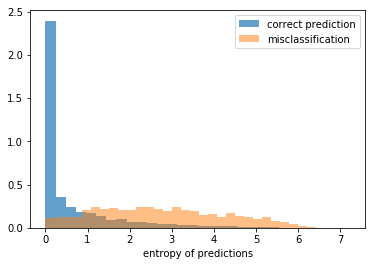

In [24]:
plt.hist(
    entropy(val_predictions[hits]), bins=30, 
    normed=True, alpha=0.7, label='correct prediction'
);
plt.hist(
    entropy(val_predictions[~hits]), bins=30, 
    normed=True, alpha=0.5, label='misclassification'
);
plt.legend();
plt.xlabel('entropy of predictions');

### confidence of predictions

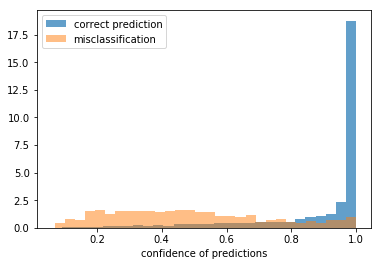

In [25]:
plt.hist(
    val_predictions[hits].max(1), bins=30, 
    normed=True, alpha=0.7, label='correct prediction'
);
plt.hist(
    val_predictions[~hits].max(1), bins=30, 
    normed=True, alpha=0.5, label='misclassification'
);
plt.legend();
plt.xlabel('confidence of predictions');

### difference between biggest and second biggest probability

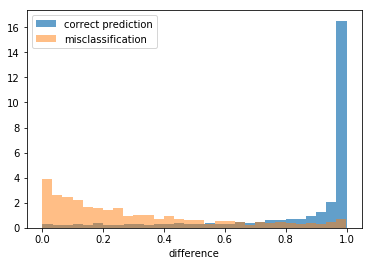

In [26]:
sorted_correct = np.sort(val_predictions[hits], 1)
sorted_incorrect = np.sort(val_predictions[~hits], 1)

plt.hist(
    sorted_correct[:, -1] - sorted_correct[:, -2], bins=30, 
    normed=True, alpha=0.7, label='correct prediction'
);
plt.hist(
    sorted_incorrect[:, -1] - sorted_incorrect[:, -2], bins=30, 
    normed=True, alpha=0.5, label='misclassification'
);
plt.legend();
plt.xlabel('difference');

### probabilistic calibration of the model

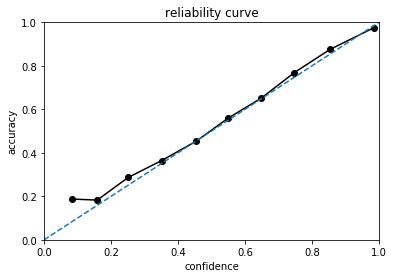

In [27]:
model_calibration(val_true_targets, val_predictions, n_bins=10)

### per class accuracies

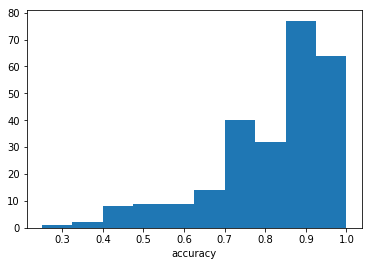

In [28]:
per_class_acc = per_class_accuracy(val_true_targets, val_predictions)
plt.hist(per_class_acc);
plt.xlabel('accuracy');

In [29]:
most_inaccurate_k_classes(per_class_acc, 15, decode)

drinking-straw 0.25
baseball-bat 0.35
mailbox 0.35
sneaker 0.4
sword 0.4
skateboard 0.4
soda-can 0.4
frog 0.45
screwdriver 0.45
playing-card 0.45
flashlight 0.45
duck 0.5
mushroom 0.5
ladder 0.5
tambourine 0.5


### class accuracy vs. number of samples in the class

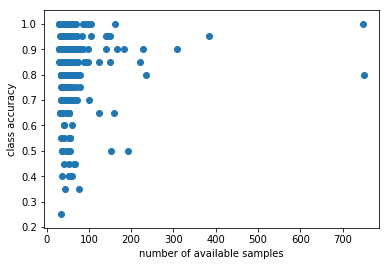

In [30]:
plt.scatter((1.0/w), per_class_acc);
plt.ylabel('class accuracy');
plt.xlabel('number of available samples');

### most confused pairs of classes

In [31]:
confused_pairs = most_confused_classes(
    val_true_targets, val_predictions, decode, min_n_confusions=4
)
confused_pairs

[('hibiscus', 'iris'),
 ('kayak', 'canoe'),
 ('laptop', 'computer-keyboard'),
 ('mandolin', 'electric-guitar'),
 ('sneaker', 'tennis-shoes'),
 ('spoon', 'tuning-fork'),
 ('swan', 'goose'),
 ('syringe', 'flashlight'),
 ('yo-yo', 'frisbee'),
 ('toad', 'frog'),
 ('chimp', 'gorilla'),
 ('chopsticks', 'baseball-bat'),
 ('chopsticks', 'drinking-straw'),
 ('duck', 'goose')]

### show some low entropy errors

In [32]:
erroneous_entropy = entropy(erroneous_predictions)
mean_entropy = erroneous_entropy.mean()
low_entropy = mean_entropy < erroneous_entropy
mean_entropy

2.7416865203107221

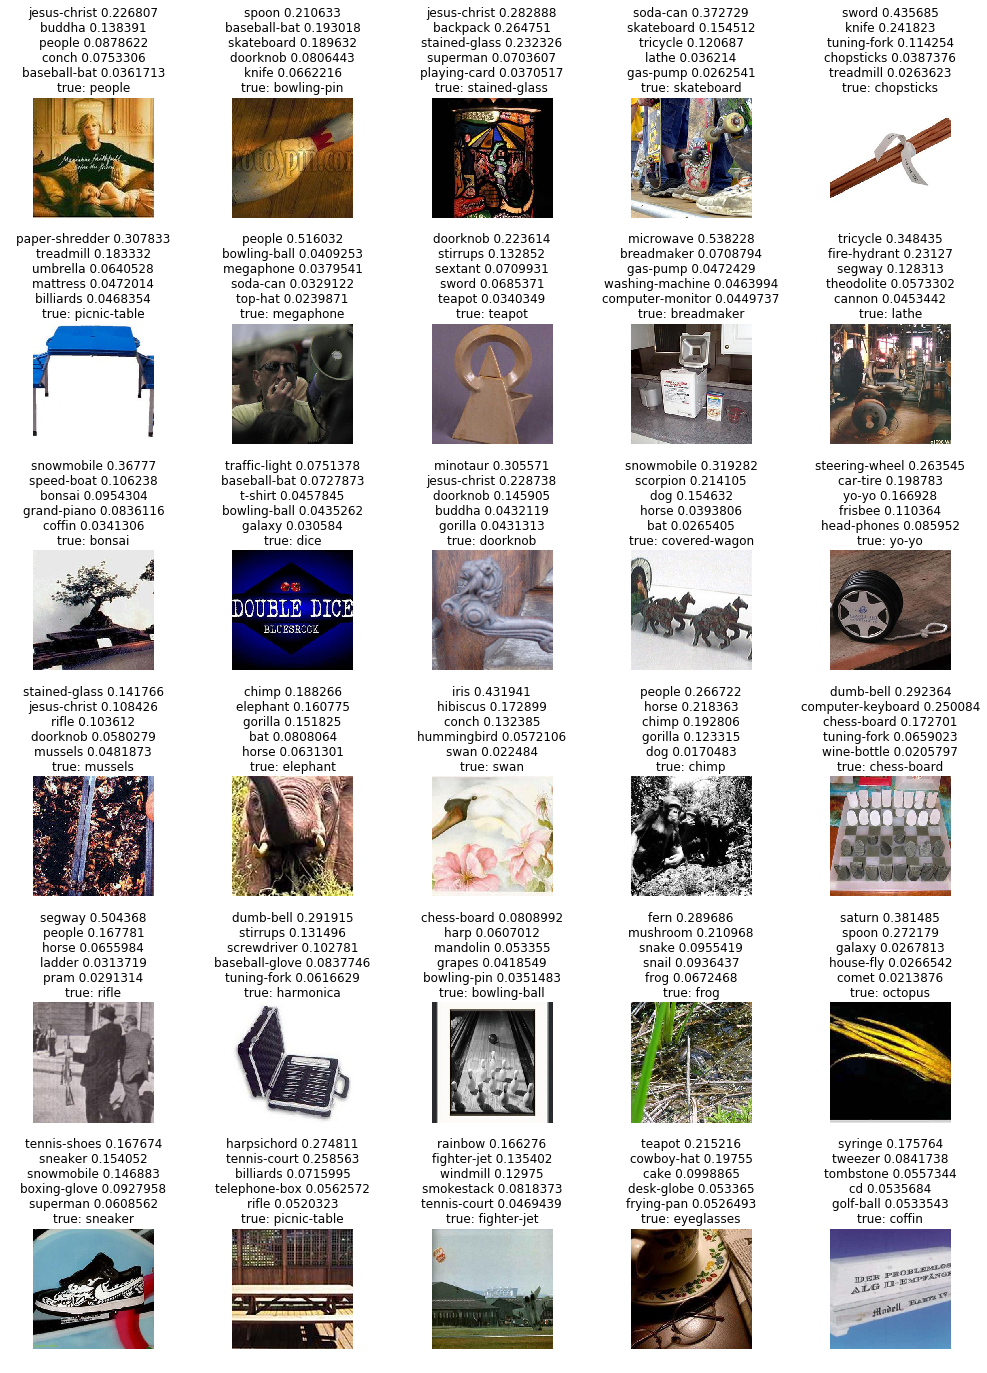

In [33]:
show_errors(
    erroneous_samples[low_entropy], 
    erroneous_predictions[low_entropy], 
    erroneous_targets[low_entropy], 
    decode
)

### show some high entropy errors

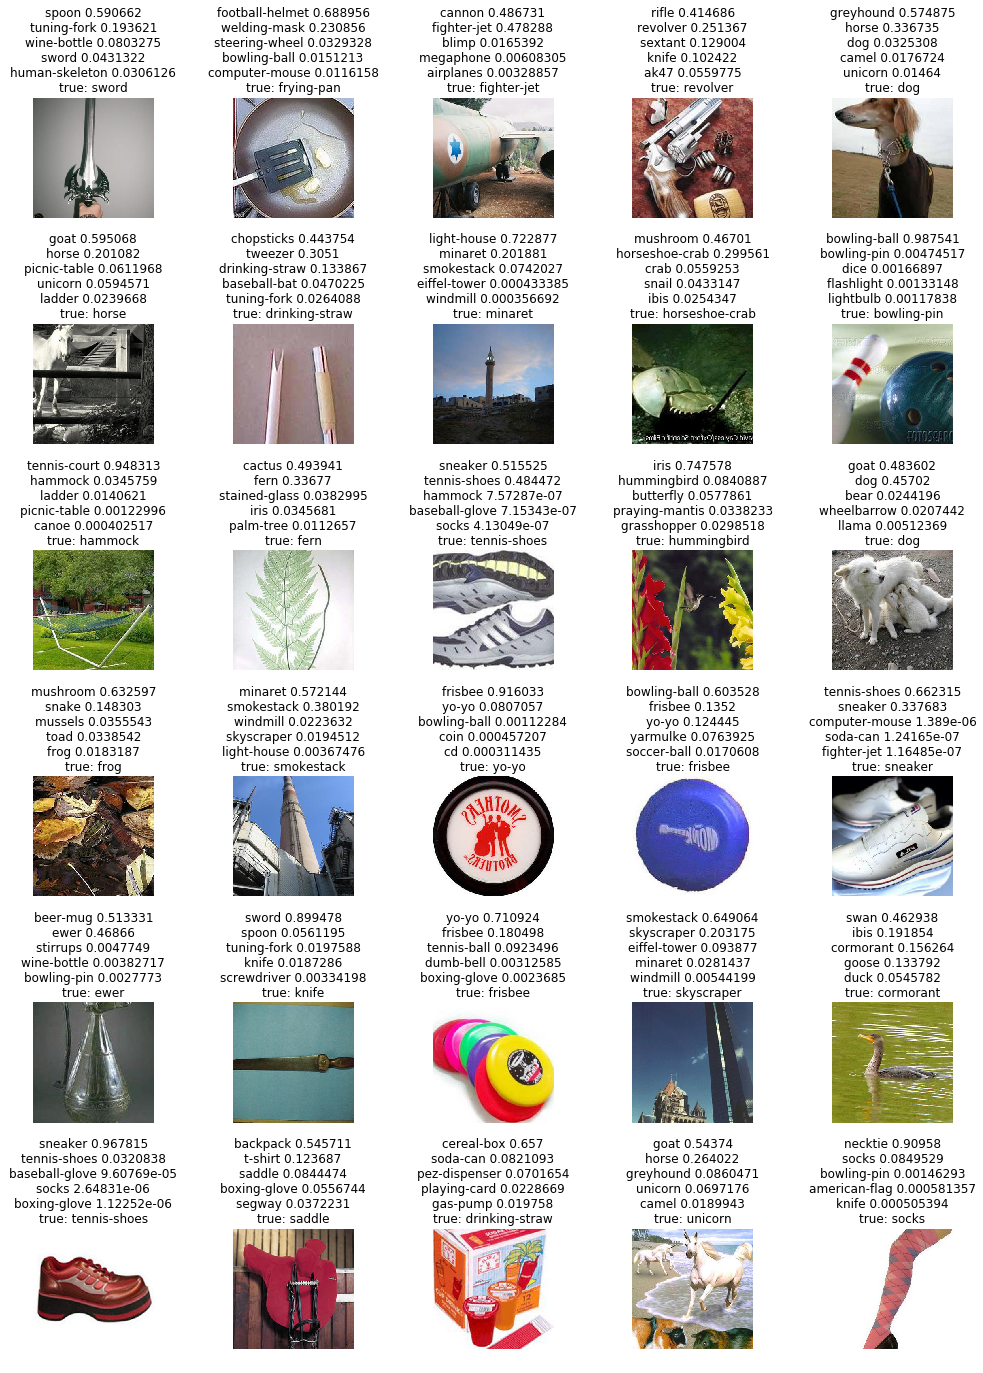

In [34]:
show_errors(
    erroneous_samples[~low_entropy], 
    erroneous_predictions[~low_entropy], 
    erroneous_targets[~low_entropy], 
    decode
)

# Save

In [35]:
model.cpu();
torch.save(model.state_dict(), 'resnet18.pytorch_state')